In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch
# ★
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=661750 sha256=b59489a24eefe89d6a5836fbcfd560a31404a365c25f8bd628c8960b9319b5b5
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%who

Interactive namespace is empty.


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
np.bool = np.bool_
import gluonnlp as nlp

from tqdm import tqdm, tqdm_notebook
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel, AdamW, get_cosine_schedule_with_warmup

# GPU 사용 시
device = torch.device("cuda:0")

# Tokenizer와 모델 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

# 데이터셋 다운로드
!wget https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1 -O ratings_train.txt
!wget https://www.dropbox.com/s/977gbwh542gdy94/ratings_test.txt?dl=1 -O ratings_test.txt
dataset_train = nlp.data.TSVDataset("ratings_train.txt", field_indices=[1,2], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset("ratings_test.txt", field_indices=[1,2], num_discard_samples=1)
subset_size = 150
dataset_train = dataset_train[:subset_size]
dataset_test = dataset_test[:subset_size]


class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return len(self.labels)

# 설정
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

# 데이터 로더
tok = tokenizer.tokenize
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size=768, num_classes=2, dr_rate=None, params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

# 옵티마이저와 스케줄러 준비
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy() / max_indices.size()[0]
    return train_acc

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

# 모델 저장
model_save_path = '/content/drive/MyDrive/kobert_model(kmh).pth' #경로 설정해주세요
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# # 모델 불러오기
# model_load_path = '/content/drive/MyDrive/kobert_model(kmh).pth'
# model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)
# model.load_state_dict(torch.load(model_load_path))
# model.eval()  # 모델을 평가 모드로 전환
# print("Model loaded and ready for inference")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

--2024-05-27 09:28:09--  https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/374ftkec978br3d/ratings_train.txt [following]
--2024-05-27 09:28:09--  https://www.dropbox.com/s/dl/374ftkec978br3d/ratings_train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca805c6348c13e15eca788c08c2.dl.dropboxusercontent.com/cd/0/get/CTqf6ziyO5QAMUBYHCImAY-wz36fsNkpmlqvjFRh40jE8hi9jJm4T2AuObKv-Dp-5ptrkzvS8egXv7s9FncQRPkzB67c5ANBbn2PxVQqesJwWhubBcBOwU3ympo7fbA_LBadJgyqN_HhLVxlhtcUynzk/file?dl=1# [following]
--2024-05-27 09:28:09--  https://uca805c6348c13e15eca788c08c2.dl.dropboxusercontent.com/cd/0/get/CTqf6ziyO5QAMUBYHCImAY-wz36fsNkpmlqvjFRh40jE8hi9jJm4T2AuObKv-Dp-5ptrkzvS8egXv7s9FncQR

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-3-7cf509263425>:106: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segme

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.7144599556922913 train acc 0.46875
epoch 1 train acc 0.5


<ipython-input-3-7cf509263425>:123: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 1 test acc 0.5160984848484849


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.6946112513542175 train acc 0.578125
epoch 2 train acc 0.5710227272727272


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 2 test acc 0.5615530303030303


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.7151646018028259 train acc 0.515625
epoch 3 train acc 0.4947916666666667


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 3 test acc 0.5970643939393939


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.6730184555053711 train acc 0.546875
epoch 4 train acc 0.5303030303030303


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 4 test acc 0.5662878787878788


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.7164694666862488 train acc 0.453125
epoch 5 train acc 0.5099431818181818


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 5 test acc 0.5355113636363636
Model saved to /content/drive/MyDrive/kobert_model(kmh).pth


In [ ]:
#예측

In [ ]:
import torch
from torch import nn  # nn 모듈 가져오기
from torch.utils.data import Dataset, DataLoader
import numpy as np
np.bool = np.bool_
import gluonnlp as nlp

from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
import matplotlib.pyplot as plt

# GPU 사용 시
device = torch.device("cuda:0")

# Tokenizer와 모델 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, bert_tokenizer, vocab, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]

    def __getitem__(self, i):
        return self.sentences[i]

    def __len__(self):
        return len(self.sentences)

# 모델 클래스 정의 (이미 정의된 상태라고 가정)
class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size=768, num_classes=2, dr_rate=None, params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# 저장된 모델 불러오기
model_load_path = '/content/drive/MyDrive/kobert_model(kmh).pth'
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)
model.load_state_dict(torch.load(model_load_path))
model.eval()  # 모델을 평가 모드로 전환

# 라벨이 없는 데이터 전처리 및 예측
def predict(sentences):
    dataset = [[sentence, 0] for sentence in sentences]  # 라벨은 임의로 0으로 설정
    data = BERTDataset(dataset, 0, tokenizer.tokenize, vocab, max_len, True, False)
    dataloader = DataLoader(data, batch_size=32, num_workers=5)

    results = []
    model.eval()
    with torch.no_grad():
        for token_ids, valid_length, segment_ids in dataloader:
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length = valid_length
            out = model(token_ids, valid_length, segment_ids)
            max_vals, max_indices = torch.max(out, 1)
            results.extend(max_indices.cpu().numpy())
    return results

# 예측할 데이터
new_sentences = [
    "재미없어",
    "재미있어",
    "새로운 문장 예시 3"
]

# 예측 수행
predictions = predict(new_sentences)
print(predictions)

# 예측 결과 시각화
def visualize_predictions(sentences, predictions):
    positive_sentences = [sentences[i] for i in range(len(sentences)) if predictions[i] == 1]
    negative_sentences = [sentences[i] for i in range(len(sentences)) if predictions[i] == 0]

    print("Positive sentences:")
    for sentence in positive_sentences:
        print(sentence)

    print("\nNegative sentences:")
    for sentence in negative_sentences:
        print(sentence)

    plt.figure(figsize=(8, 6))
    plt.bar(['Positive', 'Negative'], [len(positive_sentences), len(negative_sentences)], color=['blue', 'red'])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Sentiment Analysis Results')
    plt.show()

visualize_predictions(new_sentences, predictions)



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


NameError: name 'max_len' is not defined

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[1, 1, 0]
Positive sentences:
재미없어
재미있어

Negative sentences:
새로운 문장 예시 3


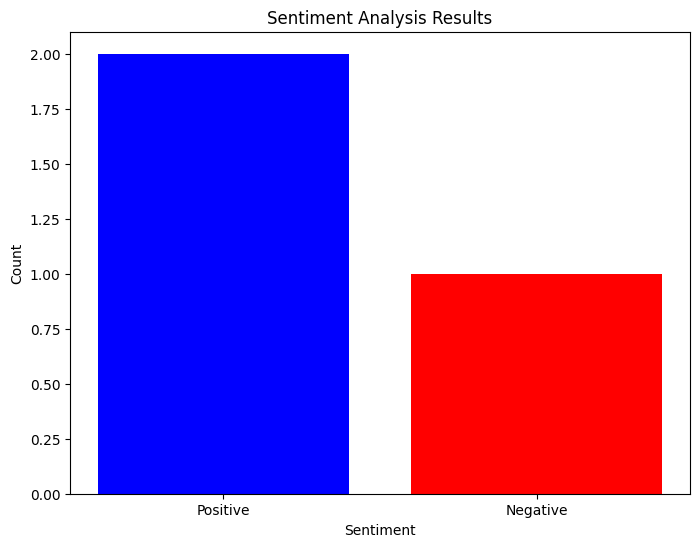

In [ ]:
import torch
from torch import nn  # nn 모듈 가져오기
from torch.utils.data import Dataset, DataLoader
import numpy as np
np.bool = np.bool_
import gluonnlp as nlp
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
import matplotlib.pyplot as plt

# GPU 사용 시
device = torch.device("cuda:0")

# Tokenizer와 모델 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, bert_tokenizer, vocab, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]

    def __getitem__(self, i):
        return self.sentences[i]

    def __len__(self):
        return len(self.sentences)

# 모델 클래스 정의 (이미 정의된 상태라고 가정)
class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size=768, num_classes=2, dr_rate=None, params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# 저장된 모델 불러오기
model_load_path = '/content/drive/MyDrive/kobert_model(kmh).pth'
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)
model.load_state_dict(torch.load(model_load_path))
model.eval()  # 모델을 평가 모드로 전환

# 라벨이 없는 데이터 전처리 및 예측
def predict(sentences):
    max_len = 64  # max_len 추가
    dataset = [[sentence, 0] for sentence in sentences]  # 라벨은 임의로 0으로 설정
    data = BERTDataset(dataset, 0, tokenizer.tokenize, vocab, max_len, True, False)
    dataloader = DataLoader(data, batch_size=32, num_workers=5)

    results = []
    model.eval()
    with torch.no_grad():
        for token_ids, valid_length, segment_ids in dataloader:
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length = valid_length
            out = model(token_ids, valid_length, segment_ids)
            max_vals, max_indices = torch.max(out, 1)
            results.extend(max_indices.cpu().numpy())
    return results

# 예측할 데이터
new_sentences = [
    "재미없어",
    "재미있어",
    "새로운 문장 예시 3"
]

# 예측 수행
predictions = predict(new_sentences)
print(predictions)

# 예측 결과 시각화
def visualize_predictions(sentences, predictions):
    positive_sentences = [sentences[i] for i in range(len(sentences)) if predictions[i] == 1]
    negative_sentences = [sentences[i] for i in range(len(sentences)) if predictions[i] == 0]

    print("Positive sentences:")
    for sentence in positive_sentences:
        print(sentence)

    print("\nNegative sentences:")
    for sentence in negative_sentences:
        print(sentence)

    plt.figure(figsize=(8, 6))
    plt.bar(['Positive', 'Negative'], [len(positive_sentences), len(negative_sentences)], color=['blue', 'red'])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Sentiment Analysis Results')
    plt.show()

visualize_predictions(new_sentences, predictions)
